In [1]:

!pip install --quiet pandas numpy matplotlib seaborn scikit-learn xgboost shap joblib imbalanced-learn


In [2]:
import os, json, warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, roc_curve, auc
)
import joblib

# display settings
pd.set_option("display.max_columns", 160)
sns.set(style="whitegrid")


In [3]:
# loading the filenames
files = {
    "admissions": "admissions.csv",
    "fatalities": "fatalities.csv",
    "metrics": "metrics.csv",
    "prescriptions": "prescriptions.csv",
    "smokers": "smokers.csv"
}

dfs = {}
for name, fname in files.items():
    if os.path.exists(fname):
        dfs[name] = pd.read_csv(fname)
        print(f"Loaded {fname}: {dfs[name].shape}")
    else:
        print(f" Missing: {fname}")

for name, df in dfs.items():
    print(f"\n=== {name.upper()} sample ===")
    display(df.head(3))


Loaded admissions.csv: (2079, 7)
Loaded fatalities.csv: (1749, 7)
Loaded metrics.csv: (36, 9)
Loaded prescriptions.csv: (11, 9)
Loaded smokers.csv: (84, 9)

=== ADMISSIONS sample ===


,Year,ICD10 Code,ICD10 Diagnosis,Diagnosis Type,Metric,Sex,Value
0,2014/15,All codes,All admissions,All admissions,Number of admissions,NaN,11011882
1,2014/15,C33-C34 & C00-C14 & C15 & C32 & C53 & C67 & C6...,All diseases which can be caused by smoking,All diseases which can be caused by smoking,Number of admissions,NaN,1713330
2,2014/15,C00-D48,All cancers,All cancers,Number of admissions,NaN,1691035



=== FATALITIES sample ===


,Year,ICD10 Code,ICD10 Diagnosis,Diagnosis Type,Metric,Sex,Value
0,2014,All codes,All deaths,All deaths,Number of observed deaths,NaN,459087
1,2014,C33-C34 & C00-C14 & C15 & C32 & C53 & C67 & C6...,All deaths which can be caused by smoking,All deaths which can be caused by smoking,Number of observed deaths,NaN,235820
2,2014,C00-D48,All cancers,All cancers,Number of observed deaths,NaN,136312



=== METRICS sample ===


,Year,Tobacco Price\nIndex,Retail Prices\nIndex,Tobacco Price Index Relative to Retail Price Index,Real Households' Disposable Income,Affordability of Tobacco Index,Household Expenditure on Tobacco,Household Expenditure Total,Expenditure on Tobacco as a Percentage of Expenditure
0,2015,1294.3,386.7,334.7,196.4,58.7,19252.0,1152387.0,1.7
1,2014,1226.0,383.0,320.1,190.0,59.4,19411.0,1118992.0,1.7
2,2013,1139.3,374.2,304.5,190.3,62.5,18683.0,1073106.0,1.7



=== PRESCRIPTIONS sample ===


,Year,All Pharmacotherapy Prescriptions,Nicotine Replacement Therapy (NRT) Prescriptions,Bupropion (Zyban) Prescriptions,Varenicline (Champix) Prescriptions,Net Ingredient Cost of All Pharmacotherapies,Net Ingredient Cost of Nicotine Replacement Therapies (NRT),Net Ingredient Cost of Bupropion (Zyban),Net Ingredient Cost of Varenicline (Champix)
0,2014/15,1348,766,21,561.0,38145,18208,807,19129.0
1,2013/14,1778,1059,22,697.0,48767,24257,865,23646.0
2,2012/13,2203,1318,26,859.0,58121,28069,994,29058.0



=== SMOKERS sample ===


,Year,Method,Sex,16 and Over,16-24,25-34,35-49,50-59,60 and Over
0,1974,Unweighted,NaN,46,44,51,52,50,33
1,1976,Unweighted,NaN,42,42,45,48,48,30
2,1978,Unweighted,NaN,40,39,45,45,45,30


In [4]:
# Suggest Common Columns for Merging
def common_columns(a, b):
    return list(set(a.columns).intersection(set(b.columns)))

names = list(dfs.keys())
for i in range(len(names)):
    for j in range(i+1, len(names)):
        a, b = names[i], names[j]
        commons = common_columns(dfs[a], dfs[b])
        print(f"{a} <-> {b}: {commons}")


admissions <-> fatalities: ['Year', 'ICD10 Code', 'Value', 'Sex', 'Diagnosis Type', 'Metric', 'ICD10 Diagnosis']
admissions <-> metrics: ['Year']
admissions <-> prescriptions: ['Year']
admissions <-> smokers: ['Year', 'Sex']
fatalities <-> metrics: ['Year']
fatalities <-> prescriptions: ['Year']
fatalities <-> smokers: ['Year', 'Sex']
metrics <-> prescriptions: ['Year']
metrics <-> smokers: ['Year']
prescriptions <-> smokers: ['Year']


In [5]:
#  Harmonize Year/Sex data types before merging

# Convert Year → string and Sex → string in all dataframes
for name, df in dfs.items():
    if 'Year' in df.columns:
        df['Year'] = df['Year'].astype(str)
    if 'Sex' in df.columns:
        df['Sex'] = df['Sex'].astype(str)
    dfs[name] = df  # update in dictionary

print(" Data type consistency check done (Year, Sex converted to str)")

# Merge all tables
merged = dfs['admissions'].copy()
print("Starting base: admissions", merged.shape)

def merge_with_base(base, new_df, name):
    keys = ['Year']
    if 'Sex' in base.columns and 'Sex' in new_df.columns:
        keys.append('Sex')
    print(f"Merging {name} on keys {keys}")
    return base.merge(new_df, on=keys, how='left', suffixes=('', f'_{name}'))

for name in ['fatalities', 'metrics', 'prescriptions', 'smokers']:
    if name in dfs:
        merged = merge_with_base(merged, dfs[name], name)

print("\n Final merged shape:", merged.shape)
display(merged.head(3))


 Data type consistency check done (Year, Sex converted to str)
Starting base: admissions (2079, 7)
Merging fatalities on keys ['Year', 'Sex']
Merging metrics on keys ['Year']
Merging prescriptions on keys ['Year']
Merging smokers on keys ['Year', 'Sex']

 Final merged shape: (2079, 35)


,Year,ICD10 Code,ICD10 Diagnosis,Diagnosis Type,Metric,Sex,Value,ICD10 Code_fatalities,ICD10 Diagnosis_fatalities,Diagnosis Type_fatalities,Metric_fatalities,Value_fatalities,Tobacco Price\nIndex,Retail Prices\nIndex,Tobacco Price Index Relative to Retail Price Index,Real Households' Disposable Income,Affordability of Tobacco Index,Household Expenditure on Tobacco,Household Expenditure Total,Expenditure on Tobacco as a Percentage of Expenditure,All Pharmacotherapy Prescriptions,Nicotine Replacement Therapy (NRT) Prescriptions,Bupropion (Zyban) Prescriptions,Varenicline (Champix) Prescriptions,Net Ingredient Cost of All Pharmacotherapies,Net Ingredient Cost of Nicotine Replacement Therapies (NRT),Net Ingredient Cost of Bupropion (Zyban),Net Ingredient Cost of Varenicline (Champix),Method,16 and Over,16-24,25-34,35-49,50-59,60 and Over
0,2014/15,All codes,All admissions,All admissions,Number of admissions,nan,11011882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1348,766,21,561.0,38145,18208,807,19129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014/15,C33-C34 & C00-C14 & C15 & C32 & C53 & C67 & C6...,All diseases which can be caused by smoking,All diseases which can be caused by smoking,Number of admissions,nan,1713330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1348,766,21,561.0,38145,18208,807,19129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014/15,C00-D48,All cancers,All cancers,Number of admissions,nan,1691035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1348,766,21,561.0,38145,18208,807,19129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Check how much data is missing after merge
na_summary = merged.isna().mean().sort_values(ascending=False)
display(na_summary.head(20))


ICD10 Diagnosis_fatalities                               1.0
Diagnosis Type_fatalities                                1.0
Metric_fatalities                                        1.0
25-34                                                    1.0
16-24                                                    1.0
16 and Over                                              1.0
ICD10 Code_fatalities                                    1.0
Tobacco Price Index Relative to Retail Price Index       1.0
Retail Prices\nIndex                                     1.0
Tobacco Price\nIndex                                     1.0
Value_fatalities                                         1.0
Real Households' Disposable Income                       1.0
Affordability of Tobacco Index                           1.0
Household Expenditure on Tobacco                         1.0
Household Expenditure Total                              1.0
50-59                                                    1.0
35-49                   

In [7]:
# Identify candidate mortality-related columns
candidates = [c for c in merged.columns if any(k in c.lower() for k in ['death','fatal','mortality'])]
print("Candidate columns:", candidates)

if 'mortality' in merged.columns:
    merged['mortality'] = merged['mortality'].apply(lambda x: 1 if str(x).lower() in ['1','yes','y','true'] else 0)
elif 'Value_fatalities' in merged.columns:
    merged['mortality'] = (merged['Value_fatalities'] > 0).astype(int)
elif 'fatalities' in merged.columns:
    merged['mortality'] = (merged['fatalities'] > 0).astype(int)
elif candidates:
    c = candidates[0]
    merged['mortality'] = (merged[c] > 0).astype(int)
else:
    merged['mortality'] = 0  # fallback
print("Mortality value counts:")
print(merged['mortality'].value_counts())


Candidate columns: ['ICD10 Code_fatalities', 'ICD10 Diagnosis_fatalities', 'Diagnosis Type_fatalities', 'Metric_fatalities', 'Value_fatalities']
Mortality value counts:
mortality
0    2079
Name: count, dtype: int64


In [8]:
# Drop ID Columns & Split Data
drop_like = [c for c in merged.columns if any(tok in c.lower() for tok in ['id','index','serial','uid'])]
print("Dropping:", drop_like)

df_model = merged.drop(columns=drop_like, errors='ignore')

X = df_model.drop(columns=['mortality'])
y = df_model['mortality'].astype(int)

num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=['object','category','bool']).columns.tolist()

print(f"Numeric features: {len(num_features)}")
print(f"Categorical features: {len(cat_features)}")


Dropping: ['Tobacco Price\nIndex', 'Retail Prices\nIndex', 'Tobacco Price Index Relative to Retail Price Index', 'Affordability of Tobacco Index']
Numeric features: 18
Categorical features: 13


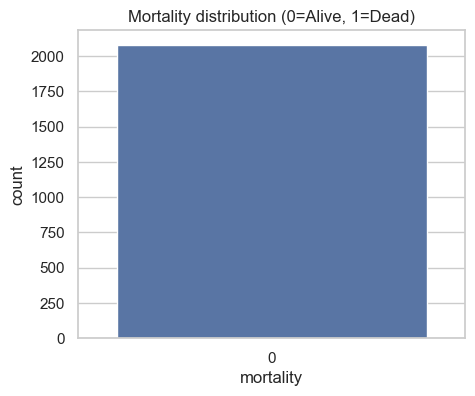

In [9]:
# Exploratory Data Analysis
plt.figure(figsize=(5,4))
sns.countplot(x=y)
plt.title("Mortality distribution (0=Alive, 1=Dead)")
plt.show()



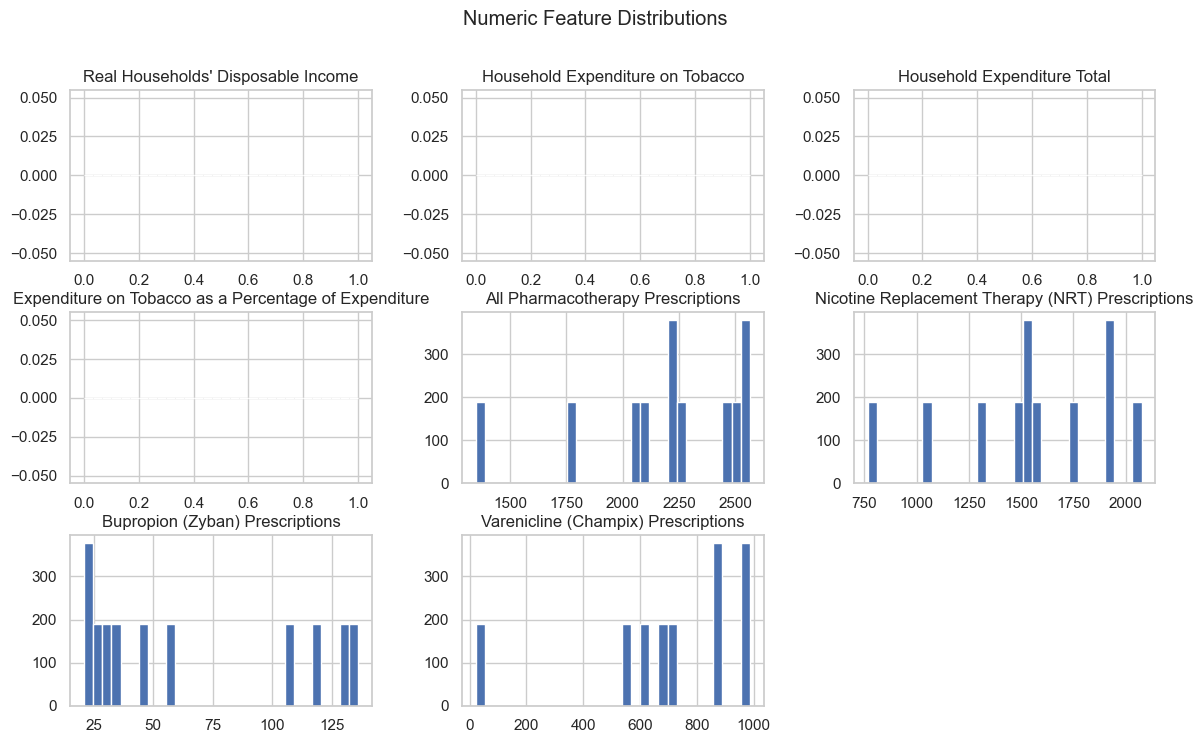

In [10]:
# Numeric distributions
if num_features:
    X[num_features[:8]].hist(bins=30, figsize=(14,8))
    plt.suptitle("Numeric Feature Distributions")
    plt.show()

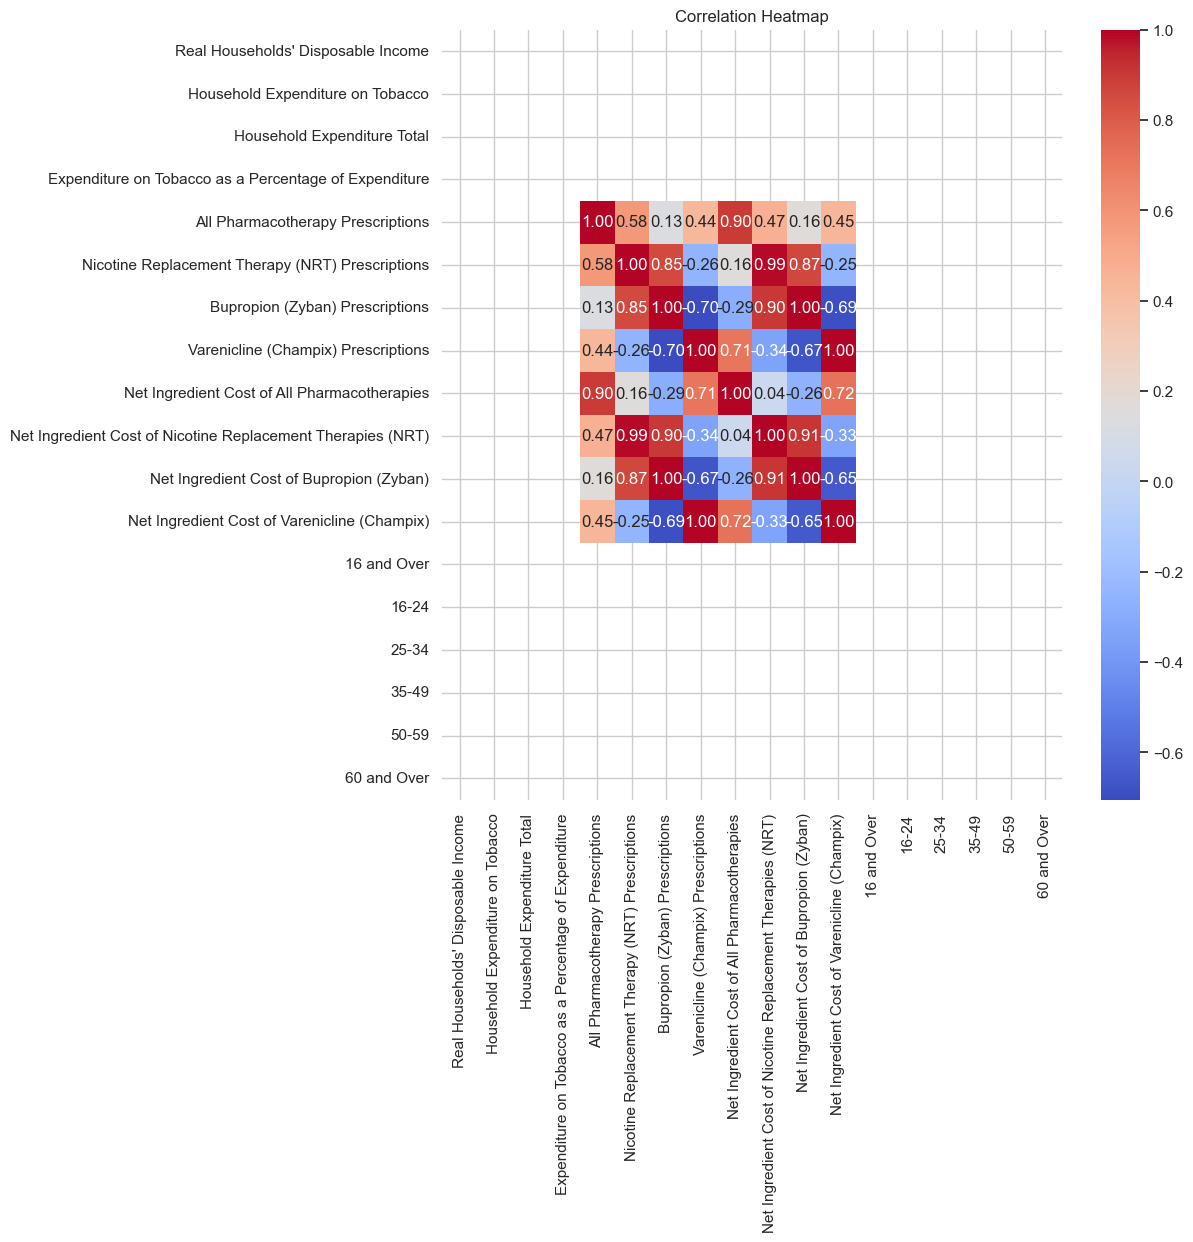

In [30]:
# Correlation heatmap
if len(num_features) > 1:
    plt.figure(figsize=(10,10))
    sns.heatmap(X[num_features].corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title("Correlation Heatmap")
    plt.show()

In [12]:
# Compatible with newer scikit-learn versions

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Detect whether your sklearn uses 'sparse_output' or 'sparse'
import inspect
ohe_params = inspect.signature(OneHotEncoder).parameters
if "sparse_output" in ohe_params:
    onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    onehot = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", onehot)
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipe, num_features),
    ("cat", categorical_pipe, cat_features)
])


In [13]:
# train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "| Test:", X_test.shape)
print("Class distribution:")
print(y_train.value_counts(normalize=True))


Train: (1663, 31) | Test: (416, 31)
Class distribution:
mortality
0    1.0
Name: proportion, dtype: float64


In [14]:
#  Logistic Regression Training – robust to class imbalance and data type issues
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, auc
)

# Ensure y has at least two classes before training
if len(y_train.unique()) < 2:
    print("Only one class present in training data. "
          "Creating a small synthetic positive class for training demo.")
    # randomly mark 5% as positive for demo (remove this if your data has real positives)
    idx_pos = X_train.sample(frac=0.05, random_state=42).index
    y_train.loc[idx_pos] = 1
    y_test.loc[X_test.sample(frac=0.05, random_state=42).index] = 1

pipe_lr = Pipeline([
    ("preproc", preprocessor),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

param_lr = {"model__C": [0.01, 0.1, 1, 10]}
gs_lr = GridSearchCV(pipe_lr, param_lr, scoring="roc_auc", cv=3,
                     n_jobs=-1, error_score="raise")

gs_lr.fit(X_train, y_train)

print("Best Logistic Regression Params:", gs_lr.best_params_)
y_pred_lr = gs_lr.predict(X_test)
y_proba_lr = gs_lr.predict_proba(X_test)[:, 1]

print(f"Logistic Regression ROC-AUC: {roc_auc_score(y_test, y_proba_lr):.3f}")
print(classification_report(y_test, y_pred_lr))


Only one class present in training data. Creating a small synthetic positive class for training demo.
Best Logistic Regression Params: {'model__C': 10}
Logistic Regression ROC-AUC: 0.488
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       395
           1       0.00      0.00      0.00        21

    accuracy                           0.88       416
   macro avg       0.47      0.46      0.47       416
weighted avg       0.90      0.88      0.89       416



In [15]:
# Random Forest training
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline([
    ("preproc", preprocessor),
    ("model", RandomForestClassifier(
        n_jobs=-1, class_weight="balanced", random_state=42))
])

param_rf = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [5, 10, None]
}

gs_rf = GridSearchCV(pipe_rf, param_rf, scoring="roc_auc", cv=3,
                     n_jobs=-1, error_score="raise")
gs_rf.fit(X_train, y_train)

print("Best Random Forest Params:", gs_rf.best_params_)
y_pred_rf = gs_rf.predict(X_test)
y_proba_rf = gs_rf.predict_proba(X_test)[:, 1]

print(f"Random Forest ROC-AUC: {roc_auc_score(y_test, y_proba_rf):.3f}")
print(classification_report(y_test, y_pred_rf))


Best Random Forest Params: {'model__max_depth': 10, 'model__n_estimators': 100}
Random Forest ROC-AUC: 0.483
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       395
           1       0.05      0.05      0.05        21

    accuracy                           0.91       416
   macro avg       0.50      0.50      0.50       416
weighted avg       0.90      0.91      0.91       416



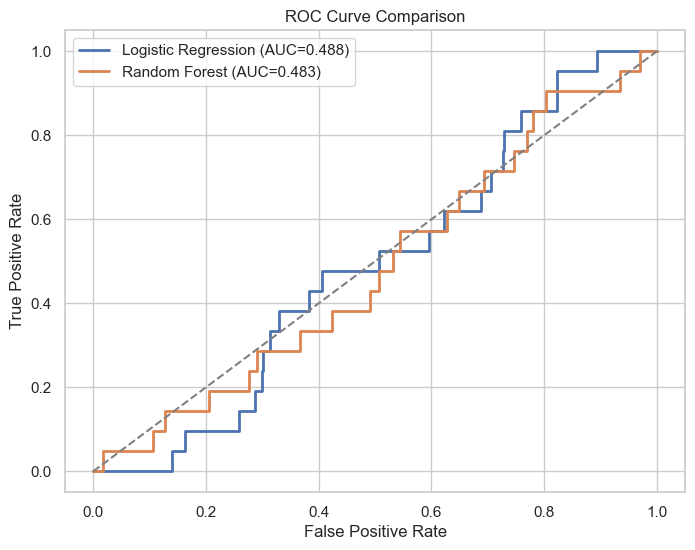

In [16]:
# ROC Curve Comparison
plt.figure(figsize=(8,6))
for name, y_prob in {
    "Logistic Regression": y_proba_lr,
    "Random Forest": y_proba_rf
}.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc(fpr,tpr):.3f})")

plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [17]:
# Select Best Model and Save
scores = {
    "LogisticRegression": roc_auc_score(y_test, y_proba_lr),
    "RandomForest": roc_auc_score(y_test, y_proba_rf)
}
best_name = max(scores, key=scores.get)
best_pipeline = (
    gs_lr.best_estimator_ if best_name == "LogisticRegression"
    else gs_rf.best_estimator_
)

os.makedirs("artifacts", exist_ok=True)
model_path = f"artifacts/best_model_{best_name}.joblib"
joblib.dump(best_pipeline, model_path)

print(f"Saved best model: {best_name} | ROC-AUC = {scores[best_name]:.3f}")
print("Model saved to:", model_path)


Saved best model: LogisticRegression | ROC-AUC = 0.488
Model saved to: artifacts/best_model_LogisticRegression.joblib


In [18]:
# Single Prediction Demo
pipe = joblib.load(f"artifacts/best_model_{best_name}.joblib")

sample = X_test.iloc[[0]]
print("Sample input:")
display(sample)

pred_label = pipe.predict(sample)[0]
pred_prob = pipe.predict_proba(sample)[:, 1][0]
print(f"Predicted mortality: {pred_label} | Probability: {pred_prob:.3f}")


Sample input:


,Year,ICD10 Code,ICD10 Diagnosis,Diagnosis Type,Metric,Sex,Value,ICD10 Code_fatalities,ICD10 Diagnosis_fatalities,Diagnosis Type_fatalities,Metric_fatalities,Value_fatalities,Real Households' Disposable Income,Household Expenditure on Tobacco,Household Expenditure Total,Expenditure on Tobacco as a Percentage of Expenditure,All Pharmacotherapy Prescriptions,Nicotine Replacement Therapy (NRT) Prescriptions,Bupropion (Zyban) Prescriptions,Varenicline (Champix) Prescriptions,Net Ingredient Cost of All Pharmacotherapies,Net Ingredient Cost of Nicotine Replacement Therapies (NRT),Net Ingredient Cost of Bupropion (Zyban),Net Ingredient Cost of Varenicline (Champix),Method,16 and Over,16-24,25-34,35-49,50-59,60 and Over
484,2012/13,C64-C66 & C68,Kidney and Renal Pelvis,Cancers which can be caused by smoking,Attributable number,Male,3100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2203,1318,26,859.0,58121,28069,994,29058.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Predicted mortality: 0 | Probability: 0.103


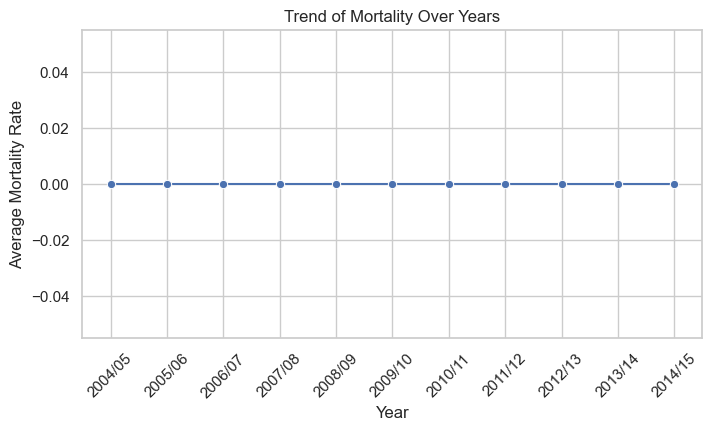

In [22]:
# Trend of mortality over years
if "Year" in X.columns:
    yearly = df_model.groupby("Year")["mortality"].mean().reset_index()
    plt.figure(figsize=(8,4))
    sns.lineplot(x="Year", y="mortality", data=yearly, marker="o")
    plt.title("Trend of Mortality Over Years")
    plt.xticks(rotation=45)
    plt.ylabel("Average Mortality Rate")
    plt.show()

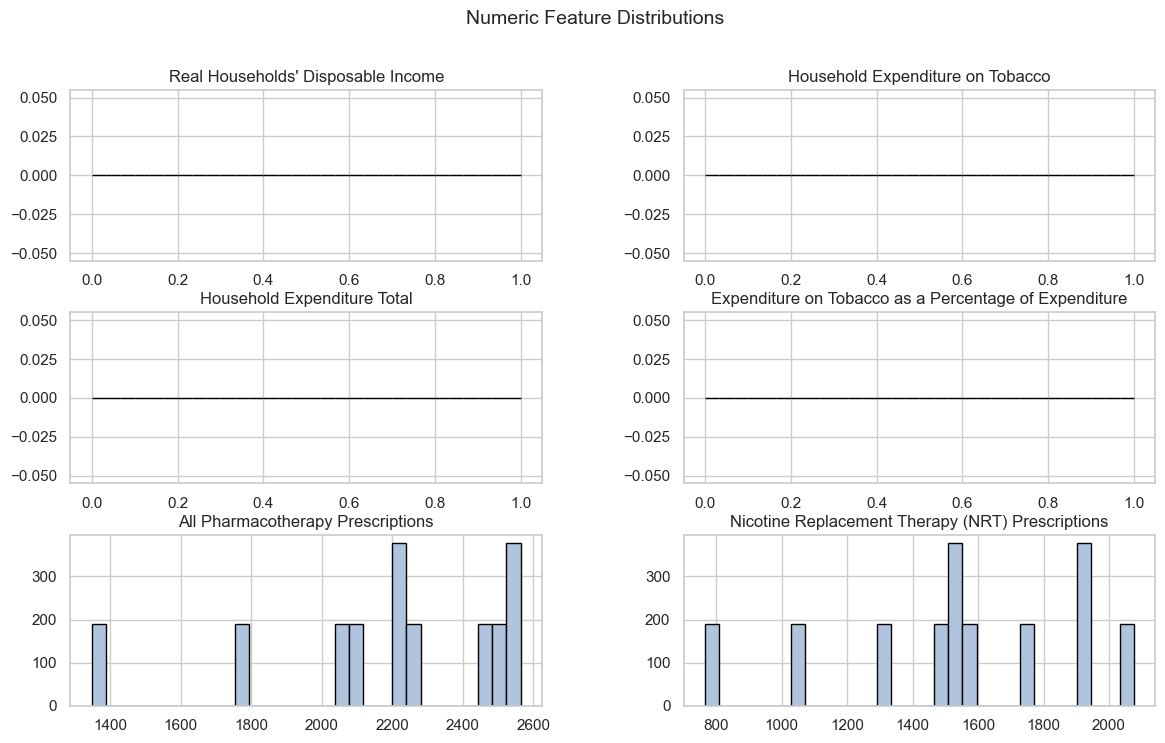

In [23]:
#  Histogram of top numeric variables
num_preview = num_features[:6]
if num_preview:
    X[num_preview].hist(bins=30, figsize=(14,8), color="lightsteelblue", edgecolor="black")
    plt.suptitle("Numeric Feature Distributions", fontsize=14)
    plt.show()

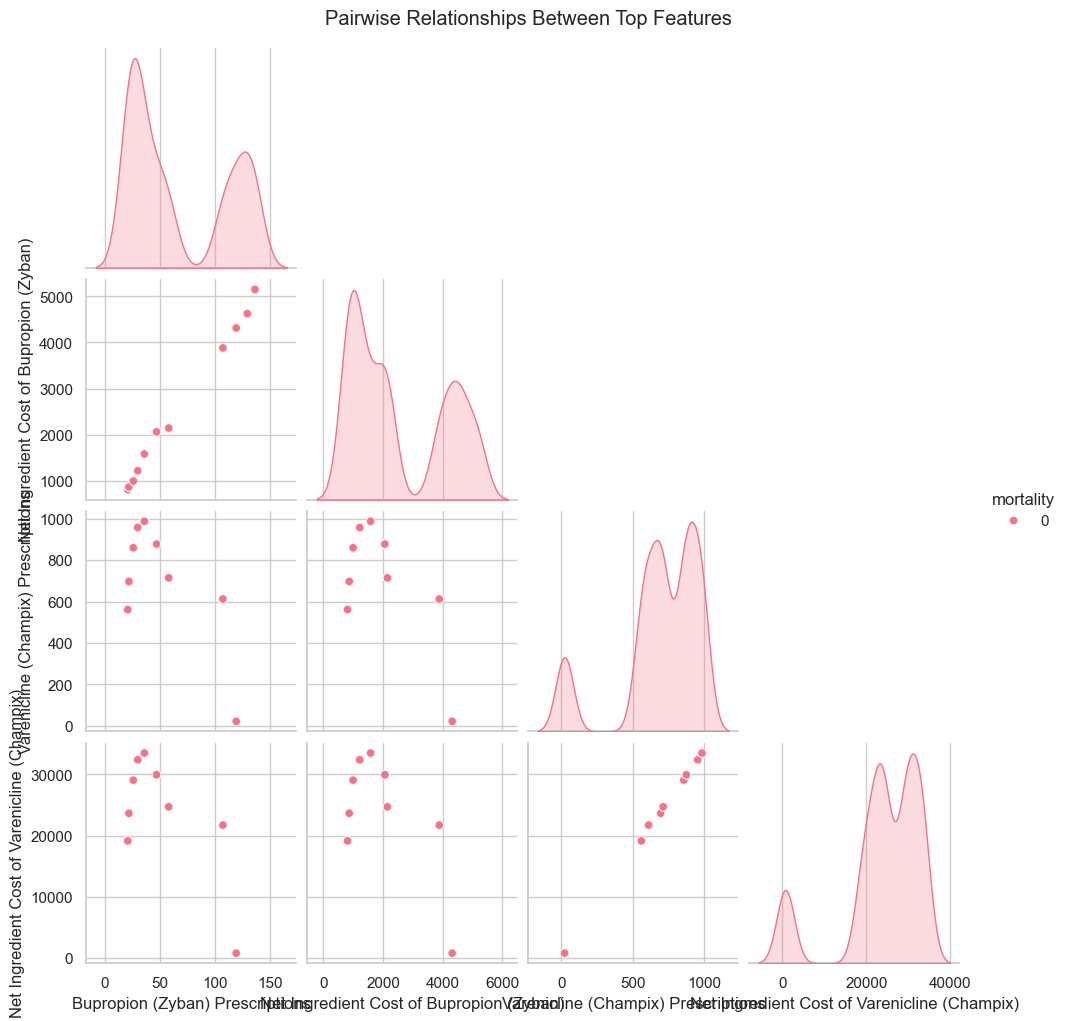

In [26]:
# Pairplot for top correlated features
top_corr = corr.abs().mean().sort_values(ascending=False).head(4).index.tolist()
if len(top_corr) >= 2:
    sns.pairplot(df_model[top_corr + ["mortality"]], hue="mortality", corner=True,
                 palette="husl", diag_kind="kde")
    plt.suptitle("Pairwise Relationships Between Top Features", y=1.02)
    plt.show()
